In [16]:
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from configuration import config
config.pythonpath_fix()



def pil_from_tensor(tensor):
    return transforms.ToPILImage()(tensor)
    
def tensor_from_pil(img):
    return transforms.ToTensor()(img)

def show_tensor(tensor_img):
    plt.figure(dpi=200)
    plt.imshow(pil_from_tensor(tensor_img), cmap='gray', vmin=0, vmax=255)

In [2]:
from deepscm.datasets.morphomnist.transforms import SetThickness, ImageMorphology
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms


image = dataset[3]["image"]

morph = ImageMorphology(image, scale=16)
tmp_morphed_img = np.float32(SetThickness(1)(morph)) 
morphed_img = torch.as_tensor(morph.downscale(tmp_morphed_img))
images = torch.cat([image, morphed_img])
grid = make_grid(images, m)
show_tensor(grid)



NameError: name 'dataset' is not defined

54000
torch.Size([32, 1, 28, 28])
_z_e.shape=torch.Size([32, 16, 7, 7])


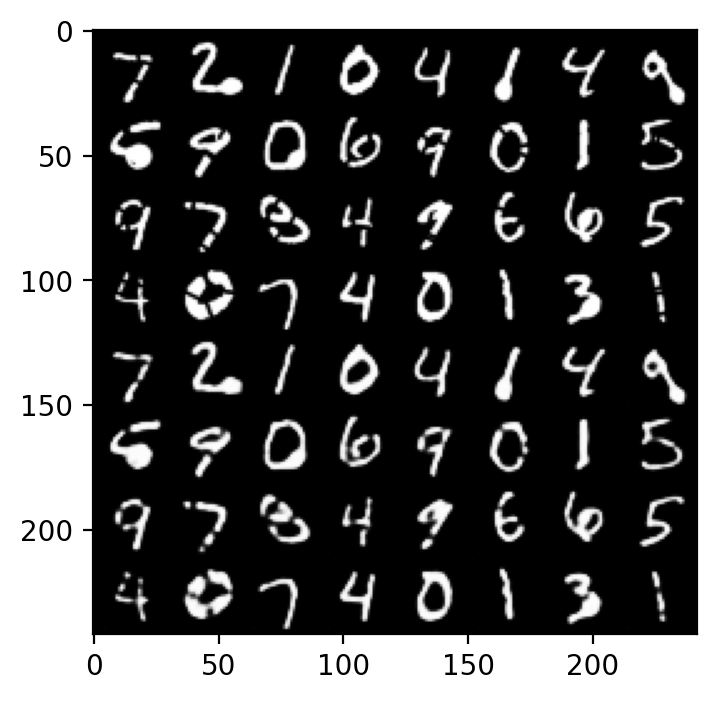

In [4]:
from ccbir.models.vqvae import VQVAEMorphoMNISTDataModule
from ccbir.models.vqvae import VQVAE
from torchvision.utils import make_grid
from torchvision import transforms

model = VQVAE.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_15/checkpoints/vqvae-morphomnist-epoch=099-val_loss=0.0202340.ckpt')

dm = VQVAEMorphoMNISTDataModule()
dm.prepare_data()
dm.setup()
print(len(dm.mnist_train))
data_loader = dm.test_dataloader()
batch = next(iter(data_loader))
images = batch['image'][:32]
print(images.shape)
#show_tensor(make_grid(images, range=(0., 1.)))

reconstructions, _z_e, _z_q = model(images)
print(f"{_z_e.shape=}")
#reconstructions=torch.max(reconstructions, torch.tensor(0))
#reconstructions=torch.abs(reconstructions)
show_tensor(make_grid(torch.cat([images, reconstructions]), normalize=True, range=(-1,1)))

unprocessed=batch['image'][0]


In [4]:
import pandas as pd

df = pd.DataFrame(
    [
        [1, 2], 
        [3, 4]
    ],
    columns=['a', 'b']
)
df.iloc[0].to_dict()
#df.to_dict(orient='records')

{'a': 1, 'b': 2}

Generating train dataset for perturbation<class 'deepscm.morphomnist.perturb.Fracture'>


100%|##########| 60000/60000 [12:00<00:00, 83.32img/s] 


{'image': <PIL.Image.Image image mode=L size=28x28 at 0x7F833AACB2B0>, 'label': tensor(0, dtype=torch.uint8), 'metrics': {}, 'perturbations_args': {'thickness': 1.5, 'prune': 2.0, 'num_frac': 3.0}}


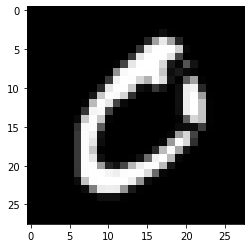

In [4]:
from ccbir.data.morphomnist.dataset import PerturbedMorphoMNIST, SwollenMorphoMNIST, FracturedMorphoMNIST
from deepscm.datasets.morphomnist import MorphoMNISTLike

test_data = MorphoMNISTLike(str(config.original_mnist_data_path), train=False)
test_data_perturbed = FracturedMorphoMNIST(train=True)
#train_data_perturbed = PerturbedMorphoMNIST(Swelling, perturbation_sampler=SwellingSampler(), train=True)

print(test_data_perturbed[1])
plt.imshow(test_data_perturbed[1]['image'], cmap='gray')



In [1]:
from configuration import config
config.pythonpath_fix()
from ccbir.models.twin_network import DeepSimpleTwinNet
from torchinfo import summary
import torch

model = DeepSimpleTwinNet(2, 20, 32, torch.Size((16, 7, 7)))
summary(model.network, (64, 2 + 20 + 32))

/vol/bitbucket/mb8318/ccbir_venv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Linear: 1-1                            [64, 128]                 7,040
├─LeakyReLU: 1-2                         [64, 128]                 --
├─Unflatten: 1-3                         [64, 128, 1, 1]           --
├─ConvTranspose2d: 1-4                   [64, 64, 3, 3]            73,792
├─BatchNorm2d: 1-5                       [64, 64, 3, 3]            128
├─LeakyReLU: 1-6                         [64, 64, 3, 3]            --
├─ConvTranspose2d: 1-7                   [64, 32, 5, 5]            18,464
├─BatchNorm2d: 1-8                       [64, 32, 5, 5]            64
├─LeakyReLU: 1-9                         [64, 32, 5, 5]            --
├─ConvTranspose2d: 1-10                  [64, 16, 7, 7]            4,624
Total params: 104,112
Trainable params: 104,112
Non-trainable params: 0
Total mult-adds (M): 87.01
Input size (MB): 0.01
Forward/backward pa

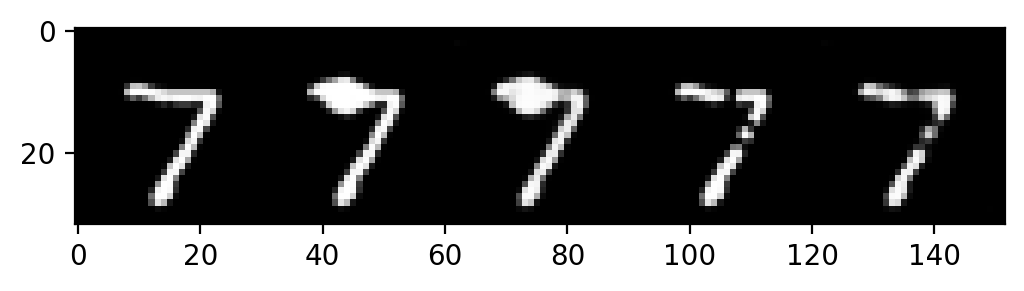

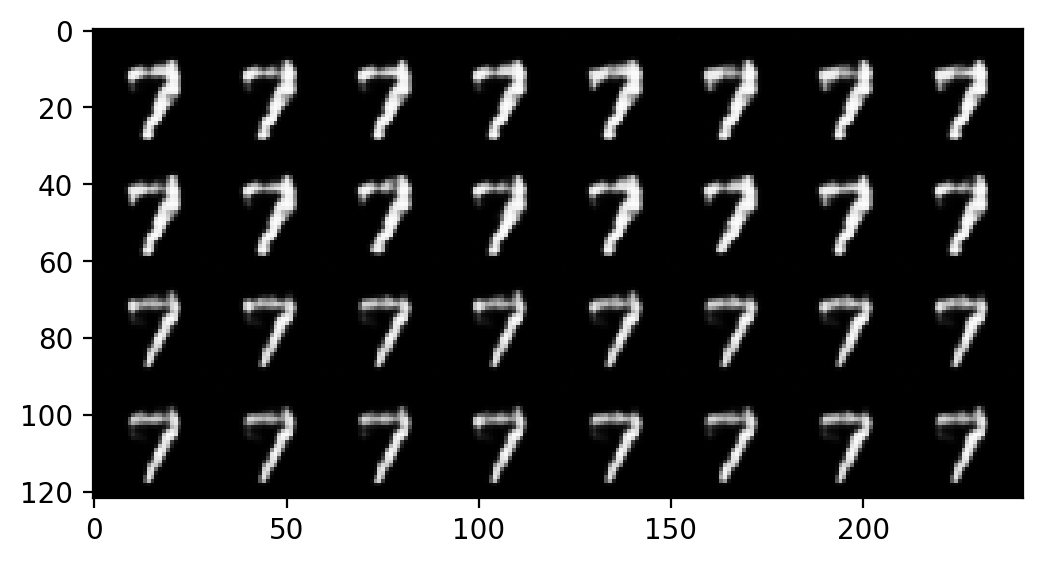

In [34]:
from ccbir.models.model import load_best_model
from ccbir.models.twin_network import PlainSwollenFracturedTwinNet, TwinNetDataModule, vqvae_embed_image
from ccbir.models.vqvae import VQVAE
from functools import partial

vqvae = load_best_model(VQVAE)
twin_net = PlainSwollenFracturedTwinNet.load_from_checkpoint(
    '/homes/mb8318/Documents/year4/ccbir/lightning_logs/version_22/checkpoints/twinnet-epoch=002-val_loss=0.2060446.ckpt'
)

datamodule = TwinNetDataModule(embed_image=partial(vqvae_embed_image, vqvae))
datamodule.setup()
test_dataloader = datamodule.test_dataloader()
batch = next(iter(test_dataloader))


def vqvae_recon(embedding):
    # print(embedding.shape)
    z_e_x = embedding
    with torch.no_grad():
        e_x = vqvae.model.codebook(z_e_x)
        return vqvae.decode(e_x)


idx = 0
idx_end = idx + 1
plain = batch['plain']
swollen = batch['swollen']
fractured = batch['fractured']
original_image = plain['image'][idx:idx_end]
swollen_image = swollen['image'][idx:idx_end]
fractured_image = fractured['image'][idx:idx_end]
swollen_embedding = swollen['embedding'][idx:idx_end]
fractured_embedding = fractured['embedding'][idx:idx_end]

# FIXME: merging of labels and calculations of one hot encoding should be done
# in preprocessing at the dataset/datamodule level rather than in the forward
# step

num_samples = 16
metrics = plain['metrics'] = {k:v[idx:idx + 1].repeat(num_samples) for k,v in plain['metrics'].items()}

swollen_embedding_hat, fractured_embedding_hat = twin_net.forward(
    plain_image_label=plain['label'][idx:idx_end].repeat(num_samples),
    plain_image_metrics=metrics,
)

images = [
    original_image,
    swollen_image, vqvae_recon(swollen_embedding),
    fractured_image, vqvae_recon(fractured_embedding),
]

images_hat = [vqvae_recon(swollen_embedding_hat), vqvae_recon(fractured_embedding_hat)]

show_tensor(make_grid(torch.cat(images), normalize=True, range=(-1, 1)))
show_tensor(make_grid(torch.cat(images_hat), normalize=True, range=(-1, 1)))
